

---



---



---



#Environment setting for GNN

In [ ]:
!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.0

In [ ]:
!pip install datasets

In [ ]:
!pip install torch torchvision torchaudio -U
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric -U

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


#Dataset loading

We chose a relatively small dataset due to the speed of training and the resources expended. The models were tested on a larger volume of data, but the results differed insignificantly, so this dataset was left.

The dataset consists of two samples and is made for toxicity detection task:

In [ ]:
from datasets import load_dataset

train_df = load_dataset("siddhant4583agarwal/sarcasm-detection-dataset", split="train").to_pandas()
test_df = load_dataset("siddhant4583agarwal/sarcasm-detection-dataset", split="test").to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


#EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6475 entries, 0 to 6474
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6475 non-null   object
 1   label   6475 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 101.3+ KB


In the train data there's:


*   6475 rows with non-null values
*   2 columns (text, label) of `types` object and `int64`



Checking for empty strings in the text column:

In [ ]:
all_columns_empty_val = train_df[(train_df['text'] == '')]

print(all_columns_empty_val.shape[0] == 0)

True


Checking for duplicates:

In [ ]:
train_df.duplicated().sum()

3

there're 3, let's drop them:

In [ ]:
train_df = train_df.drop_duplicates()

Now, let's see if there are any
repeating rows between samples (train, test) and remove them:

In [ ]:
train_set = set(tuple(row) for row in train_df.values)
test_set = set(tuple(row) for row in test_df.values)

duplicates = train_set.intersection(test_set)

if duplicates:
  print(f"{len(duplicates)} duplicates found.")
  print(duplicates)
else:
  print("No duplicates found.")

1 duplicates found.
{('st miras college for girls organises a webinar on expedition to mount everest', 0)}


In [ ]:
test_df[test_df['text'].str.startswith('st miras college for girls')]

,text,label
543,st miras college for girls organises a webinar...,0


In [ ]:
test_df = test_df[~test_df['text'].str.startswith('st miras college for girls', na=False)]

Next, we look at the balance of classes:

In [ ]:
import matplotlib.pyplot as plt

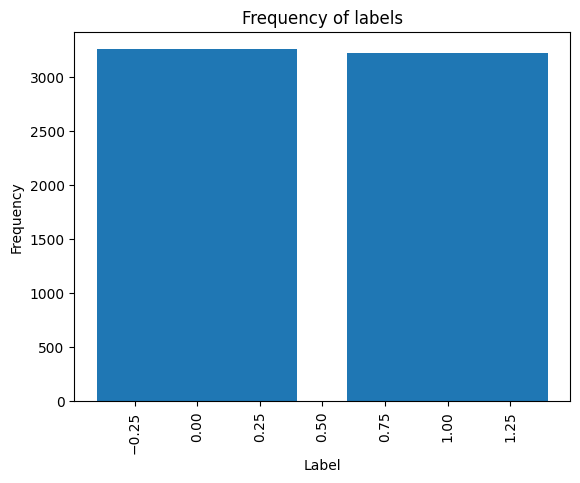

In [ ]:
label_count = train_df.label.value_counts()

plt.bar(label_count.index, label_count)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of labels')
plt.xticks(rotation=90)

plt.show()

Classes are balanced

In [ ]:
train_df.head()

,text,label
0,Samuthirakani and Kaali Venkat play the leads ...,0
1,Arnab’s security guards take down noisy panell...,1
2,Gandhi Rohini Hattangadi Arif Ali Honar Soon M...,0
3,Athiya Shetty: My father's success or failure ...,0
4,Bhupinder Singh Hooda contests BJP claim on Sw...,0




---



---



---



#Text preprocessing

In [ ]:
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data, DataLoader
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')

from gensim.models import Word2Vec
from sklearn.utils.class_weight import compute_class_weight

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Punctuation and stop-words are removed, texts are lowered:

In [ ]:
def preprocess_text(text):
  stop_words = set(stopwords.words('english'))
  tokens = word_tokenize(text.lower())
  tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
  return tokens

train_df['tokens'] = train_df['text'].apply(preprocess_text)
test_df['tokens'] = test_df['text'].apply(preprocess_text)

#Vectorization

We settled on a vector of dimension 50 with the accompanying parameters:

In [ ]:
def train_word2vec(train_df):
  sentences = train_df['tokens'].tolist()
  w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)
  return w2v_model

w2v_model = train_word2vec(train_df)

##Making graphs

- Words (their vectors) from the column 'tokens' are becoming nodes of graphs.

Those nodes are connected by edges, if they are within `window_size` of each other.

Then nodes are converted to indices (`node2idx`).

- Edges (`edge_index`) are created as a PyTorch tensor with said indices
- The target value is converted to tensor as well

Finally, data is packed into `Data(x=X, edge_index=edge_index, y=y)`, which is a standart approach while working with graphs



In [ ]:
def create_document_graph(tokens, w2v_model, label, window_size=5):
  G = nx.Graph()

  for i, word in enumerate(tokens):
    if word in w2v_model.wv:
      if word not in G:
        G.add_node(word)
      for j in range(i + 1, min(i + window_size + 1, len(tokens))):
        if tokens[j] in w2v_model.wv:
          G.add_edge(tokens[i], tokens[j])

  if G.number_of_nodes() == 0:
    return None

  node2idx = {node: i for i, node in enumerate(G.nodes())}

  X = []
  for node in G.nodes():
    if node in w2v_model.wv:
      X.append(w2v_model.wv[node])
    else:
      X.append(np.zeros(w2v_model.vector_size))

  X = torch.tensor(np.array(X), dtype=torch.float)

  edge_index = torch.tensor([[node2idx[u], node2idx[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()

  y = torch.tensor(label, dtype=torch.long)

  data = Data(x=X, edge_index=edge_index, y=y)

  return data

In [ ]:
train_graphs = [create_document_graph(tokens, w2v_model, label)
                for tokens, label in zip(train_df['tokens'], train_df['label'])]

test_graphs = [create_document_graph(tokens, w2v_model, label)
               for tokens, label in zip(test_df['tokens'], test_df['label'])]

train_graphs = [graph for graph in train_graphs if graph is not None]
test_graphs = [graph for graph in test_graphs if graph is not None]

In [ ]:
train_graphs[:5], len(train_graphs)

([Data(x=[8, 50], edge_index=[2, 25], y=0),
  Data(x=[7, 50], edge_index=[2, 20], y=1),
  Data(x=[10, 50], edge_index=[2, 35], y=0),
  Data(x=[7, 50], edge_index=[2, 20], y=0),
  Data(x=[8, 50], edge_index=[2, 25], y=0)],
 6475)

#Graph models

In [ ]:
import torch_geometric.nn as pyg_nn
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, BatchNorm, GraphNormб SAGEConv, TopKPooling
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch_geometric.nn import TransformerConv, global_mean_pool, BatchNorm
from torch_geometric.nn import GlobalAttention
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

###Training function

Also applying early stopping:

In [ ]:
class EarlyStopping:
  def __init__(self, patience=4, restore_best_weights=True):
    self.patience = patience
    self.restore_best_weights = restore_best_weights
    self.counter = 0
    self.best_loss = float('inf')
    self.best_weights = None

  def __call__(self, val_loss, model):
    if val_loss < self.best_loss:
      self.best_loss = val_loss
      self.best_weights = model.state_dict()
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

So, `seed()` is here to fix `random` with which we split train on train and validation




train_and_evaluate() function:
1. splits data into train and val (if val_dataset is not passed)
2. creates DataLoaders for batch training and validation
3. Trains the model for passed to the function number of epochs:
- does the forward pass
- calculates the criterion error
- does the backward propagation
- updates weights by `optimizer.step()`
- calculates train_loss and train_acc and with `torch.no_grad()` does the validation evaluation
4. uses `EarlyStopping` class if patience is specified


and returns lists of losses and accuracies on train and val

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)


def train_and_evaluate(model, dataset, optimizer, criterion, epochs=50, val_split=0.1,
                       batch_size=32, device='cpu', val_dataset=None, patience=None):
  if val_dataset is None:
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size

    set_seed(42)

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
  else:
    train_dataset, val_dataset = dataset, val_dataset

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  model = model.to(device)

  early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

  t_loss = []
  t_acc = []
  v_loss = []
  v_acc = []

  for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in train_loader:
      batch = batch.to(device)
      optimizer.zero_grad()

      out = model(batch)
      loss = criterion(out, batch.y)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      preds = out.argmax(dim=1)
      train_correct += (preds == batch.y).sum().item()
      train_total += batch.y.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    t_loss.append(train_loss)
    t_acc.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
      for batch in val_loader:
        batch = batch.to(device)
        val_out = model(batch)
        loss = criterion(val_out, batch.y)

        val_loss += loss.item()
        val_preds = val_out.argmax(dim=1)
        val_correct += (val_preds == batch.y).sum().item()
        val_total += batch.y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    v_loss.append(val_loss)
    v_acc.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} -- '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print()

    if patience is not None:
      if early_stopping(val_loss, model):
        print(f"Early stopping at epoch {epoch+1}")
        if early_stopping.restore_best_weights:
          model.load_state_dict(early_stopping.best_weights)
          break

  return t_loss, t_acc, v_loss, v_acc

###Evaluation function

There's not much to say, the function predicts labels for test data and calculates metrics `test_loss, test_acc, precision, recall, f1`, also outputting a confusion matrix and classification report

In [ ]:
def evaluate_model(model, test_loader, criterion, device="cpu"):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in test_loader:
      batch = batch
      out = model(batch)
      loss = criterion(out, batch.y)
      test_loss += loss.item()

      preds = out.argmax(dim=1).cpu().numpy()
      labels = batch.y.cpu().numpy()

      all_preds.extend(preds)
      all_labels.extend(labels)

      correct += (preds == labels).sum()
      total += len(labels)

  test_loss /= len(test_loader)
  test_acc = correct / total

  precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
  recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
  f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

  print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
  print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

  print("\n\nClassification Report:\n\n", classification_report(all_labels, all_preds), '\n')

  cm = confusion_matrix(all_labels, all_preds)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(all_labels), yticklabels=set(all_labels))
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

  return test_loss, test_acc, precision, recall, f1

##GCN

In the class below there are actually three types of models to choose from whili initiazing:

-`GCN`'s features:  
- `GCNConv` – special convolutional layers that pass information between neighboring nodes
- `BatchNorm` – obviously, for feature normalization to stabilize learning
- `ReLU` activation is used
- `Dropout` which can be tuned while initialization
- `Global Mean Pooling`, which averages features of all nodes to obtain a graph representation
- `Linear` layers for the classification

-`GAT` uses:
- `GATConv` that is an attention mechanism that weighs the contribution of neighboring nodes
- `Multi-Head Attention` with tunable number of heads
- `BatchNorm, ReLU, Dropout` also
- `Global Mean Pooling`, which pools info across the entire graph
- Finishing with `linear` layers

-`SAGE` main features:
- `SAGEConv` - instead of simply summing or averaging node features (like GCN), GraphSAGE learns how to sample and aggregate information from a node’s neighbors
- `TopKPooling` -- dynamically reduces the number of nodes by keeping only the most important ones.

Other than that the model uses the basic kit `BatchNorm, ReLU, Dropout, Global Mean Pooling, linear layers`

In [ ]:
class GraphClassifier(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, model_type="GCN", dropout=0.5, num_layers=4, heads=4):
    super(GraphClassifier, self).__init__()

    self.model_type = model_type
    self.dropout = dropout
    self.num_layers = num_layers

    if model_type == "GCN":
      self.convs = torch.nn.ModuleList()
      self.bns = torch.nn.ModuleList()
      for i in range(num_layers):
        in_dim = input_dim if i == 0 else hidden_dim
        self.convs.append(GCNConv(in_dim, hidden_dim))
        self.bns.append(BatchNorm(hidden_dim))

    elif model_type == "GAT":
      self.convs = torch.nn.ModuleList()
      self.bns = torch.nn.ModuleList()
      for i in range(num_layers):
        in_dim = input_dim if i == 0 else hidden_dim * heads
        self.convs.append(GATConv(in_dim, hidden_dim, heads=heads, concat=True))
        self.bns.append(BatchNorm(hidden_dim * heads))
      hidden_dim *= heads

    elif model_type == "SAGE":
      for i in range(num_layers):
        in_dim = input_dim if i == 0 else hidden_dim
        self.convs.append(SAGEConv(in_dim, hidden_dim))
        self.pool1 = pyg_nn.TopKPooling(hidden_dim, ratio=0.8)
        self.lin1 = nn.Linear(hidden_dim * 2, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, 32)
        self.lin4 = nn.Linear(32, 1)
        self.bns.append(BatchNorm(hidden_dim))
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)

    else:
      raise ValueError("Incorrect model type, use 'GCN', 'GAT' or 'SAGE'")

    self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
    self.fc2 = torch.nn.Linear(hidden_dim // 2, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch

    for i in range(self.num_layers):
      x_residual = x
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)

      if i > 0:
        x += x_residual

    x = global_mean_pool(x, batch)
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.fc2(x)

    return x

**Initializing the GCN model** with chosen parameters:

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

model = GraphClassifier(input_dim=50, hidden_dim=120, output_dim=2, model_type="GCN")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

criterion = torch.nn.CrossEntropyLoss()

history = train_and_evaluate(model, train_graphs, optimizer, criterion,
                             epochs=30, batch_size=64, val_split=0.2, patience=3)

Epoch 1/30: Train Loss: 0.6829, Train Acc: 0.5524 -- Val Loss: 0.6686, Val Acc: 0.5792

Epoch 2/30: Train Loss: 0.6478, Train Acc: 0.5994 -- Val Loss: 0.6432, Val Acc: 0.6108

Epoch 3/30: Train Loss: 0.6370, Train Acc: 0.6141 -- Val Loss: 0.6273, Val Acc: 0.6309

Epoch 4/30: Train Loss: 0.6212, Train Acc: 0.6382 -- Val Loss: 0.6072, Val Acc: 0.6641

Epoch 5/30: Train Loss: 0.6136, Train Acc: 0.6533 -- Val Loss: 0.6031, Val Acc: 0.6710

Epoch 6/30: Train Loss: 0.6091, Train Acc: 0.6562 -- Val Loss: 0.5932, Val Acc: 0.6780

Epoch 7/30: Train Loss: 0.5971, Train Acc: 0.6681 -- Val Loss: 0.5904, Val Acc: 0.6564

Epoch 8/30: Train Loss: 0.5808, Train Acc: 0.6855 -- Val Loss: 0.5809, Val Acc: 0.6633

Epoch 9/30: Train Loss: 0.5795, Train Acc: 0.6886 -- Val Loss: 0.5680, Val Acc: 0.6734

Epoch 10/30: Train Loss: 0.5739, Train Acc: 0.6853 -- Val Loss: 0.5655, Val Acc: 0.6633

Epoch 11/30: Train Loss: 0.5682, Train Acc: 0.6950 -- Val Loss: 0.5597, Val Acc: 0.6842

Epoch 12/30: Train Loss: 0.564

**Charts**

In [ ]:
t_loss, t_acc, v_loss, v_acc = history

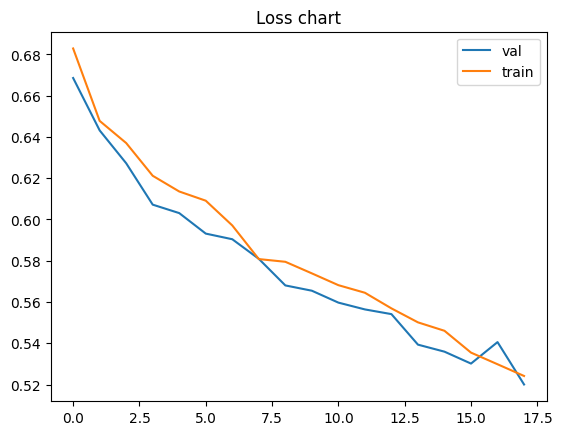

In [ ]:
plt.plot(v_loss[:18], label='val')
plt.plot(t_loss[:18], label='train')
plt.legend(loc='upper right')
plt.title('Loss chart')
plt.show()

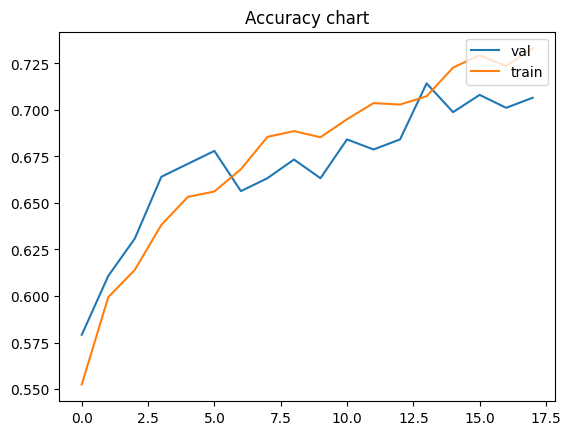

In [ ]:
plt.plot(v_acc[:18], label='val')
plt.plot(t_acc[:18], label='train')
plt.legend(loc='upper right')
plt.title('Accuracy chart')
plt.show()

According to the graphs, the model is trained quite consistently with the selected parameters: the loss graphs decrease for two samples, and the accuracy for them increases.

###Evaluation of GCN:

Test Loss: 0.5600, Test Accuracy: 0.6910
Precision: 0.7055, Recall: 0.6880, F1 Score: 0.6832


Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.55      0.63       792
           1       0.66      0.83      0.73       826

    accuracy                           0.69      1618
   macro avg       0.71      0.69      0.68      1618
weighted avg       0.70      0.69      0.68      1618
 



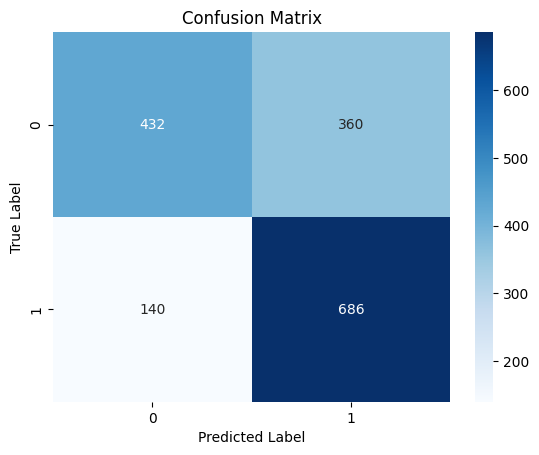

In [ ]:
test_loader = DataLoader(test_graphs, batch_size=64, shuffle=False)

test_loss, test_acc, precision, recall, f1 = evaluate_model(model, test_loader, criterion)

As we see, the model in our implementation failed to demonstrate high accuracy on the test data.

In addition, it is observed that class 0 is less stable than class 1 and is often predicted incorrectly by the model.


##GAT (with self-attention)

Now let's initialize the next model

Number of heads and layers here is 4 (default values)

In [ ]:
model_gat = GraphClassifier(input_dim=50, hidden_dim=32, output_dim=2, model_type="GAT")

optimizer = torch.optim.AdamW(model_gat.parameters(), lr=0.0005)

criterion = torch.nn.CrossEntropyLoss()


history = train_and_evaluate(model_gat, train_graphs, optimizer, criterion,
                             epochs=30, batch_size=32, val_split=0.1, patience=3)

Epoch 1/30: Train Loss: 0.6845, Train Acc: 0.5572 -- Val Loss: 0.6528, Val Acc: 0.5988

Epoch 2/30: Train Loss: 0.6516, Train Acc: 0.5980 -- Val Loss: 0.6350, Val Acc: 0.6296

Epoch 3/30: Train Loss: 0.6409, Train Acc: 0.6188 -- Val Loss: 0.6131, Val Acc: 0.6574

Epoch 4/30: Train Loss: 0.6282, Train Acc: 0.6394 -- Val Loss: 0.5975, Val Acc: 0.6651

Epoch 5/30: Train Loss: 0.6146, Train Acc: 0.6518 -- Val Loss: 0.5845, Val Acc: 0.6836

Epoch 6/30: Train Loss: 0.6139, Train Acc: 0.6453 -- Val Loss: 0.5848, Val Acc: 0.6728

Epoch 7/30: Train Loss: 0.6065, Train Acc: 0.6585 -- Val Loss: 0.5699, Val Acc: 0.6775

Epoch 8/30: Train Loss: 0.5927, Train Acc: 0.6683 -- Val Loss: 0.5586, Val Acc: 0.6852

Epoch 9/30: Train Loss: 0.5865, Train Acc: 0.6710 -- Val Loss: 0.5569, Val Acc: 0.6975

Epoch 10/30: Train Loss: 0.5809, Train Acc: 0.6777 -- Val Loss: 0.5513, Val Acc: 0.7083

Epoch 11/30: Train Loss: 0.5690, Train Acc: 0.6870 -- Val Loss: 0.5228, Val Acc: 0.7284

Epoch 12/30: Train Loss: 0.560

**Charts**

In [ ]:
t_loss, t_acc, v_loss, v_acc = history

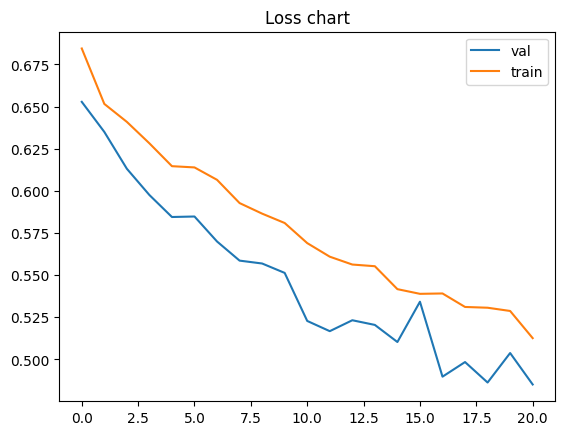

In [ ]:
plt.plot(v_loss[:21], label='val')
plt.plot(t_loss[:21], label='train')
plt.legend(loc='upper right')
plt.title('Loss chart')
plt.show()

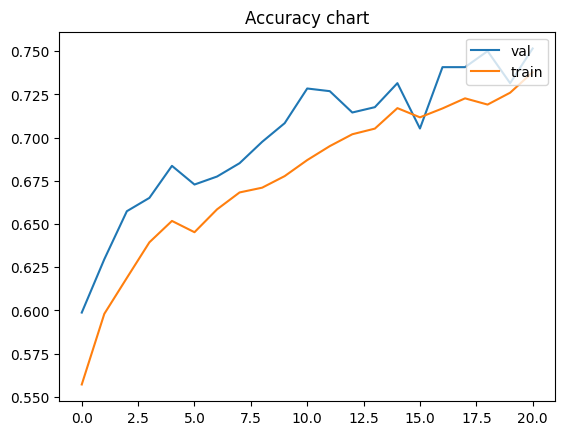

In [ ]:
plt.plot(v_acc[:21], label='val')
plt.plot(t_acc[:21], label='train')
plt.legend(loc='upper right')
plt.title('Accuracy chart')
plt.show()

Although there are some fluctuations, the model followed the correct loss and accuracy trends before the stop

###Evaluation of GAT:

Test Loss: 0.5379, Test Accuracy: 0.7244
Precision: 0.7244, Recall: 0.7245, F1 Score: 0.7243


Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.73      0.72       792
           1       0.74      0.72      0.73       826

    accuracy                           0.72      1618
   macro avg       0.72      0.72      0.72      1618
weighted avg       0.72      0.72      0.72      1618
 



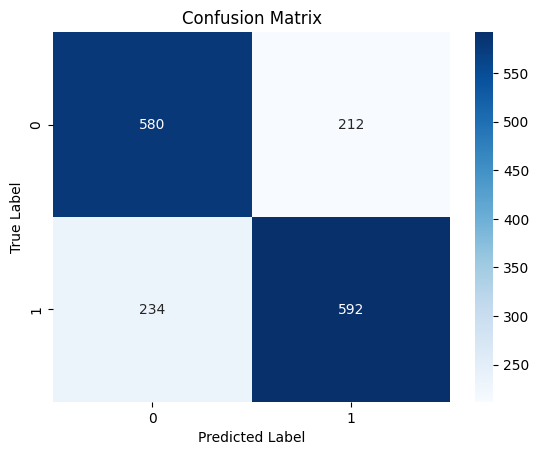

In [ ]:
test_loss, test_acc, precision, recall, f1 = evaluate_model(model_gat, test_loader, criterion)

Thia model shows better accuracy results and also takes into account class 0 much better, which the first model often failed to predict correctly

##SAGE

In [ ]:
model = GraphClassifier(input_dim=50, hidden_dim=120, output_dim=2, model_type="SAGE")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()


history = train_and_evaluate(model, train_graphs, optimizer, criterion,
                             epochs=17, batch_size=64, val_split=0.2, patience=3,
                             scheduler=scheduler)

Epoch 1/17: Train Loss: 0.6623, Train Acc: 0.5779 -- Val Loss: 0.6627, Val Acc: 0.5761

Epoch 2/17: Train Loss: 0.6343, Train Acc: 0.6287 -- Val Loss: 0.6333, Val Acc: 0.6247

Epoch 3/17: Train Loss: 0.6260, Train Acc: 0.6361 -- Val Loss: 0.6242, Val Acc: 0.6417

Epoch 4/17: Train Loss: 0.6151, Train Acc: 0.6463 -- Val Loss: 0.6109, Val Acc: 0.6471

Epoch 5/17: Train Loss: 0.6052, Train Acc: 0.6515 -- Val Loss: 0.6045, Val Acc: 0.6517

Epoch 6/17: Train Loss: 0.5957, Train Acc: 0.6625 -- Val Loss: 0.5827, Val Acc: 0.6734

Epoch 7/17: Train Loss: 0.5872, Train Acc: 0.6670 -- Val Loss: 0.5784, Val Acc: 0.6857

Epoch 8/17: Train Loss: 0.5822, Train Acc: 0.6844 -- Val Loss: 0.5626, Val Acc: 0.7042

Epoch 9/17: Train Loss: 0.5707, Train Acc: 0.6929 -- Val Loss: 0.5563, Val Acc: 0.7097

Epoch 10/17: Train Loss: 0.5629, Train Acc: 0.6935 -- Val Loss: 0.5435, Val Acc: 0.7073

Epoch 11/17: Train Loss: 0.5593, Train Acc: 0.7021 -- Val Loss: 0.5401, Val Acc: 0.7236

Epoch 12/17: Train Loss: 0.542

**Graphs**

In [ ]:
t_loss, t_acc, v_loss, v_acc = history

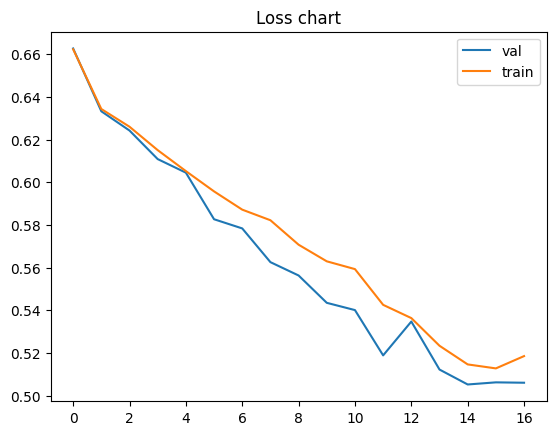

In [ ]:
plt.plot(v_loss, label='val')
plt.plot(t_loss, label='train')
plt.legend(loc='upper right')
plt.title('Loss chart')
plt.show()

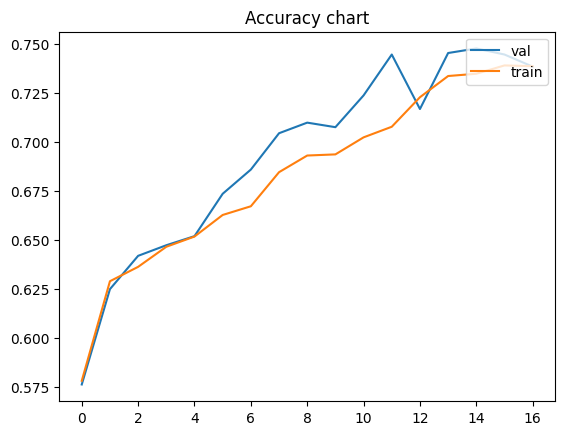

In [ ]:
plt.plot(v_acc, label='val')
plt.plot(t_acc, label='train')
plt.legend(loc='upper right')
plt.title('Accuracy chart')
plt.show()

The overall trend for this graph is that both training and validation loss decrease steadily over epochs, indicating that the model is learning. Only towards the end the curves show instability

*EarlyStopping stops the training, taking the weights from epoch 15 (14 on the graph). All in all, everything goes fine

###Evaluation of SAGE

Test Loss: 0.5254, Test Accuracy: 0.7328
Precision: 0.7476, Recall: 0.7354, F1 Score: 0.7301


Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.85      0.76       791
           1       0.81      0.62      0.70       826

    accuracy                           0.73      1617
   macro avg       0.75      0.74      0.73      1617
weighted avg       0.75      0.73      0.73      1617
 



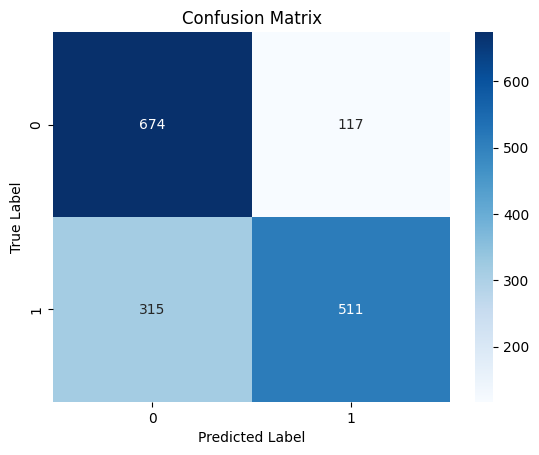

In [ ]:
test_loader = DataLoader(test_graphs, batch_size=64, shuffle=False)

test_loss, test_acc, precision, recall, f1 = evaluate_model(model, test_loader, criterion)

We see that although the accuracy of the model is higher than the previous ones, the model often incorrectly predicts the labels for texts from class 1

##GAT with transformer-based attention (TransformerConv)

In our next model we tried to use an improved attention mechanism - `TransformerConv`. It is supposed to additionaly take into account the relationships between nodes via the transformer mechanism, unlike the `GATConv` from the model above

`global_mean_pool` is also used here to average the features of all graph nodes to obtain a single representation

Apart from that, all other components of the model are pretty much similar to the previous one (multi-head attention, normalization...)

In [ ]:
class TransformerGATClassifier(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, heads=4, dropout=0.5):
    super(TransformerGATClassifier, self).__init__()

    self.dropout = dropout
    self.num_layers = num_layers

    self.convs = torch.nn.ModuleList()
    self.bns = torch.nn.ModuleList()

    for i in range(num_layers):
      in_dim = input_dim if i == 0 else hidden_dim * heads
      self.convs.append(TransformerConv(in_dim, hidden_dim, heads=heads, concat=True))
      self.bns.append(BatchNorm(hidden_dim * heads))

    hidden_dim *= heads

    self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
    self.fc2 = torch.nn.Linear(hidden_dim // 2, output_dim)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch

    for i in range(self.num_layers):
      x_residual = x
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
      if i > 0:
        x += x_residual

    x = global_mean_pool(x, batch)

    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.fc2(x)

    return x

**Initializing** with the chosen parameters

In [ ]:
model_tr = TransformerGATClassifier(input_dim=50, hidden_dim=64, output_dim=2,
                                    dropout=0.2, heads=2, num_layers=3)
optimizer = torch.optim.AdamW(model_tr.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

history = train_and_evaluate(model_tr, train_graphs, optimizer, criterion,
                             epochs=30, batch_size=32, val_split=0.1, patience=3)

Epoch 1/30: Train Loss: 0.6615, Train Acc: 0.5881 -- Val Loss: 0.6375, Val Acc: 0.6312

Epoch 2/30: Train Loss: 0.6295, Train Acc: 0.6429 -- Val Loss: 0.6036, Val Acc: 0.6806

Epoch 3/30: Train Loss: 0.6087, Train Acc: 0.6703 -- Val Loss: 0.5772, Val Acc: 0.7099

Epoch 4/30: Train Loss: 0.5908, Train Acc: 0.6889 -- Val Loss: 0.5617, Val Acc: 0.7114

Epoch 5/30: Train Loss: 0.5868, Train Acc: 0.6971 -- Val Loss: 0.5530, Val Acc: 0.7114

Epoch 6/30: Train Loss: 0.5726, Train Acc: 0.6976 -- Val Loss: 0.5617, Val Acc: 0.7145

Epoch 7/30: Train Loss: 0.5651, Train Acc: 0.7091 -- Val Loss: 0.5409, Val Acc: 0.7284

Epoch 8/30: Train Loss: 0.5563, Train Acc: 0.7121 -- Val Loss: 0.5435, Val Acc: 0.7207

Epoch 9/30: Train Loss: 0.5461, Train Acc: 0.7225 -- Val Loss: 0.5289, Val Acc: 0.7330

Epoch 10/30: Train Loss: 0.5431, Train Acc: 0.7220 -- Val Loss: 0.5280, Val Acc: 0.7361

Epoch 11/30: Train Loss: 0.5350, Train Acc: 0.7304 -- Val Loss: 0.5190, Val Acc: 0.7438

Epoch 12/30: Train Loss: 0.530

**Graphs**

In [ ]:
t_loss, t_acc, v_loss, v_acc = history

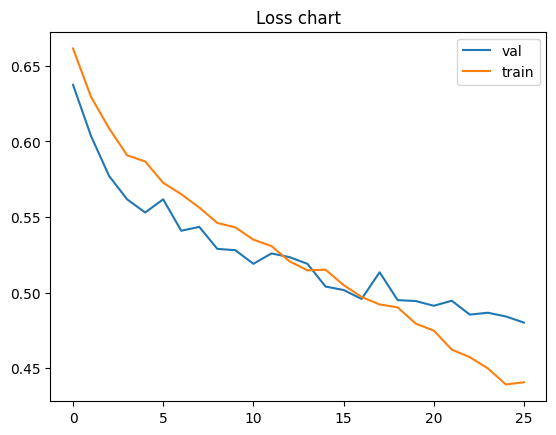

In [ ]:
plt.plot(v_loss[:26], label='val')
plt.plot(t_loss[:26], label='train')
plt.legend(loc='upper right')
plt.title('Loss chart')
plt.show()

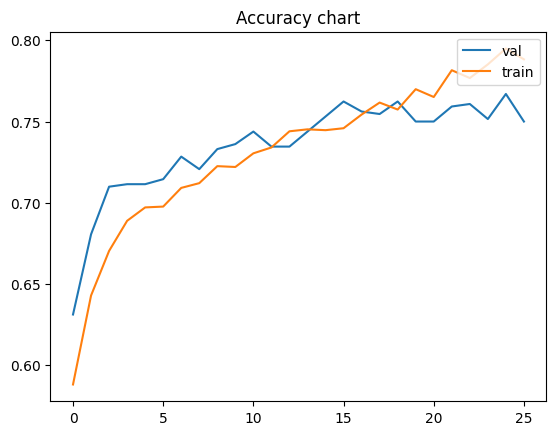

In [ ]:
plt.plot(v_acc[:26], label='val')
plt.plot(t_acc[:26], label='train')
plt.legend(loc='upper right')
plt.title('Accuracy chart')
plt.show()

The tendencies are once again fine, but we here we again couldn't tune the model to get results any better. It usually gets stuck at this accuracy value and can't go up further

###Evaluation of GAT with transformer-based attention

Test Loss: 0.5464, Test Accuracy: 0.7355
Precision: 0.7376, Recall: 0.7364, F1 Score: 0.7353


Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.78      0.74       792
           1       0.77      0.69      0.73       826

    accuracy                           0.74      1618
   macro avg       0.74      0.74      0.74      1618
weighted avg       0.74      0.74      0.74      1618
 



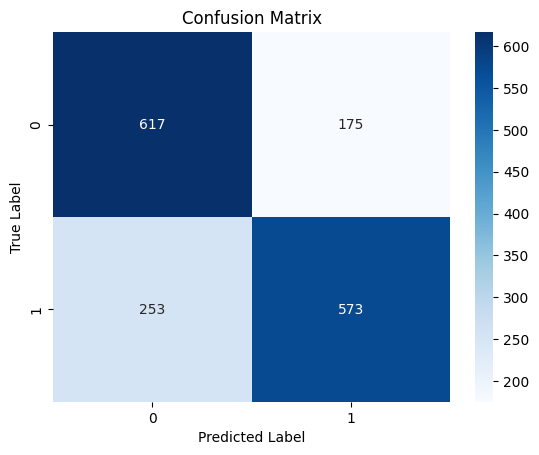

In [ ]:
test_loss, test_acc, precision, recall, f1 = evaluate_model(model_tr, test_loader, criterion)

With this type of attention evaluation results got again a bit higher

##GAT with Edge-weighted attention

The next GAT model we are trying out is with Edge-weighted attention.

It also consists of `GATConv`, but with `edge_dim=1`, which helps the model taks into account the weights of edges when transmitting information, which makes it more sensitive to the structure of the graph

As for normalization, `GraphNorm` is used

In [ ]:
class EdgeWeightedGAT(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, num_heads=4, dropout=0.5, residual=True):
    super(EdgeWeightedGAT, self).__init__()

    self.num_layers = num_layers
    self.residual = residual
    self.dropout = nn.Dropout(dropout)

    self.gat_layers = nn.ModuleList()
    self.gat_layers.append(GATConv(input_dim, hidden_dim, heads=num_heads, concat=True, edge_dim=1))

    self.norm_layers = nn.ModuleList()
    self.norm_layers.append(GraphNorm(hidden_dim * num_heads))

    for _ in range(num_layers - 1):
      self.gat_layers.append(GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True, edge_dim=1))
      self.norm_layers.append(GraphNorm(hidden_dim * num_heads))

    self.fc1 = nn.Linear(hidden_dim * num_heads, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

    if self.residual:
      self.residual_proj = nn.Linear(input_dim, hidden_dim * num_heads)

  def forward(self, data):
      x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

      for i in range(self.num_layers):
        x_residual = x

        x = self.gat_layers[i](x, edge_index, edge_attr)
        x = self.norm_layers[i](x)
        x = F.relu(x)
        x = self.dropout(x)

        if self.residual:
          if x_residual.shape[1] != x.shape[1]:
            x_residual = self.residual_proj(x_residual)
          x = x + x_residual

      x = global_mean_pool(x, batch)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)

      return x

In [ ]:
model_edge = EdgeWeightedGAT(input_dim=50, hidden_dim=64, output_dim=2, num_layers=2,
                             num_heads=2, dropout=0.4)

optimizer = torch.optim.Adam(model_edge.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

history = train_and_evaluate(model_edge, train_graphs, optimizer, criterion, epochs=50,
                             batch_size=64, val_split=0.1, patience=3)

Epoch 1/50: Train Loss: 0.6611, Train Acc: 0.5874 -- Val Loss: 0.6352, Val Acc: 0.6157

Epoch 2/50: Train Loss: 0.6325, Train Acc: 0.6190 -- Val Loss: 0.6074, Val Acc: 0.6574

Epoch 3/50: Train Loss: 0.6145, Train Acc: 0.6420 -- Val Loss: 0.5869, Val Acc: 0.6590

Epoch 4/50: Train Loss: 0.5952, Train Acc: 0.6580 -- Val Loss: 0.5744, Val Acc: 0.6867

Epoch 5/50: Train Loss: 0.5857, Train Acc: 0.6703 -- Val Loss: 0.5674, Val Acc: 0.6960

Epoch 6/50: Train Loss: 0.5812, Train Acc: 0.6702 -- Val Loss: 0.5503, Val Acc: 0.6975

Epoch 7/50: Train Loss: 0.5670, Train Acc: 0.6902 -- Val Loss: 0.5518, Val Acc: 0.7068

Epoch 8/50: Train Loss: 0.5573, Train Acc: 0.6952 -- Val Loss: 0.5399, Val Acc: 0.7160

Epoch 9/50: Train Loss: 0.5518, Train Acc: 0.7072 -- Val Loss: 0.5211, Val Acc: 0.7423

Epoch 10/50: Train Loss: 0.5455, Train Acc: 0.7110 -- Val Loss: 0.5246, Val Acc: 0.7330

Epoch 11/50: Train Loss: 0.5320, Train Acc: 0.7193 -- Val Loss: 0.5124, Val Acc: 0.7253

Epoch 12/50: Train Loss: 0.524

**Graphs**

In [ ]:
t_loss, t_acc, v_loss, v_acc = history

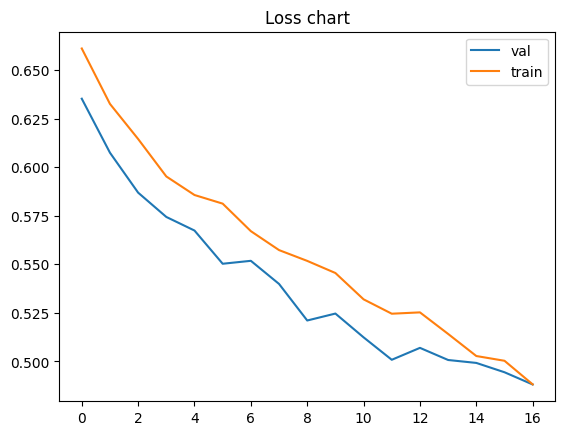

In [ ]:
plt.plot(v_loss[:17], label='val')
plt.plot(t_loss[:17], label='train')
plt.legend(loc='upper right')
plt.title('Loss chart')
plt.show()

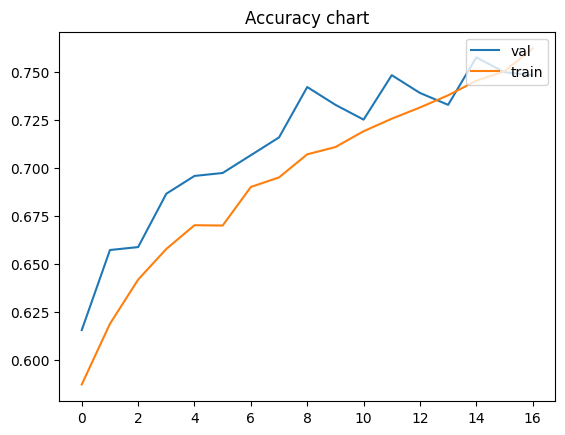

In [ ]:
plt.plot(v_acc[:17], label='val')
plt.plot(t_acc[:17], label='train')
plt.legend(loc='upper right')
plt.title('Accuracy chart')
plt.show()

The fitting seems to be going fine before the early stopping

###Evaluation of GAT with edge-weighted attention

Test Loss: 0.5417, Test Accuracy: 0.7231
Precision: 0.7237, Recall: 0.7235, F1 Score: 0.7231


Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.74      0.72       792
           1       0.74      0.70      0.72       826

    accuracy                           0.72      1618
   macro avg       0.72      0.72      0.72      1618
weighted avg       0.72      0.72      0.72      1618
 



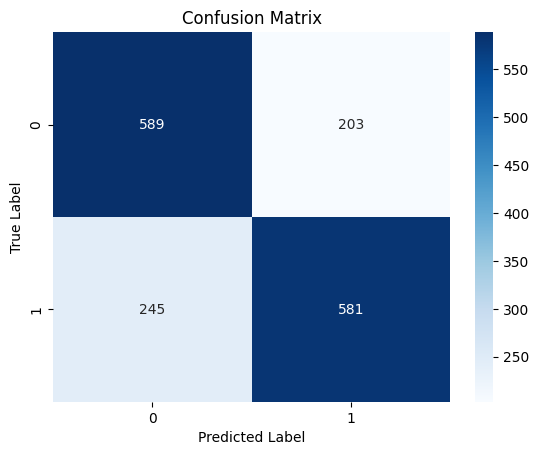

In [ ]:
test_loss, test_acc, precision, recall, f1 = evaluate_model(model_edge, test_loader, criterion)

Again, the acceptable results, but we can't get much more by tuning the parameters

#DADGNN


Now let's follow the example of implementing the graph model from the article, attempting to build a similar one

In [ ]:
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, global_mean_pool

##Creating a graph with directed symmetric edges

In theory, last time when making graphs we did the same, but since the article said about *directionality* on par with *symmetry*, we decided to test `DiGraph`. Nothing changed much from this, but okay, we just manually set the directions between words.

Also, for this model, the window_size of 4 was considered optimal.

In [ ]:
def create_document_graph2(tokens, w2v_model, label, window_size=4):
  G = nx.DiGraph()

  for i, word in enumerate(tokens):
    if word in w2v_model.wv:
      if word not in G:
        G.add_node(word)
      for j in range(i + 1, min(i + window_size + 1, len(tokens))):
        if tokens[j] in w2v_model.wv:
          G.add_edge(tokens[i], tokens[j])
          G.add_edge(tokens[j], tokens[i])

  if G.number_of_nodes() == 0:
    return None

  node2idx = {node: i for i, node in enumerate(G.nodes())}

  X = []
  for node in G.nodes():
    if node in w2v_model.wv:
      X.append(w2v_model.wv[node])
    else:
      X.append(np.zeros(w2v_model.vector_size))

  X = torch.tensor(np.array(X), dtype=torch.float)
  edge_index = torch.tensor([[node2idx[u], node2idx[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()
  y = torch.tensor(label, dtype=torch.long)

  data = Data(x=X, edge_index=edge_index, y=y)

  return data

In [ ]:
train_graphs = [create_document_graph2(tokens, w2v_model, label)
                for tokens, label in zip(train_df['tokens'], train_df['label'])]

test_graphs = [create_document_graph2(tokens, w2v_model, label)
               for tokens, label in zip(test_df['tokens'], test_df['label'])]

In [ ]:
train_graphs[:3]

[Data(x=[8, 50], edge_index=[2, 44], y=0),
 Data(x=[7, 50], edge_index=[2, 36], y=1),
 Data(x=[10, 50], edge_index=[2, 60], y=0)]

In [ ]:
len(train_graphs)

6475

##Making a diffusion attention class & the model itself

getting validation data:

In [ ]:
set_seed(74)

train_size = int((1 - 0.1) * len(train_graphs))
val_size = len(train_graphs) - train_size
train_dataset, val_dataset = random_split(train_graphs, [train_size, val_size])

For the proposed in the article attantion for graphs we do the following steps:

1. Creating a projection of input features onto the spaces of keys (K), queries (Q), and values ​​(V). W_Q, W_K, W_V are the training matrices (implemented as `nn.Linear`).

2. Applying `layer normalization` to normalize Q, K, V, which stabilizes training.

3. Spreading attention along the edges of the graph (`propagate`) - for each node i and its neighbor j, we are calculating attention in message().

4. Calculating attention coefficients in `message()` by using the dot product, applying softmax for normalization (exponential normalization) and weighting the value of V_j by this coefficient

5. Aggregating information in `update()`

In [ ]:
class DiffusiveAttentionLayer(MessagePassing):
  def __init__(self, in_channels, out_channels, alpha, residual=False):
    super(DiffusiveAttentionLayer, self).__init__(aggr='add')
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.alpha = alpha
    self.residual = residual

    self.lin_query = nn.Linear(in_channels, out_channels, bias=False)
    self.lin_key = nn.Linear(in_channels, out_channels, bias=False)
    self.lin_value = nn.Linear(in_channels, out_channels, bias=False)

    self.layer_norm = nn.LayerNorm(out_channels)

    if self.residual:
      self.res_fc = nn.Linear(in_channels, out_channels, bias=False)

  def forward(self, x, edge_index):
    Q = self.lin_query(x)
    K = self.lin_key(x)
    V = self.lin_value(x)

    Q = self.layer_norm(Q)
    K = self.layer_norm(K)
    V = self.layer_norm(V)

    return self.propagate(edge_index, Q=Q, K=K, V=V)

  def message(self, Q_i, K_j, V_j):
    attn = (Q_i * K_j).sum(dim=-1)
    attn = F.leaky_relu(attn)
    attn = torch.exp(attn)
    attn = attn / (attn.sum() + 1e-8)

    return attn.unsqueeze(-1) * V_j

  def update(self, aggr_out, x):
    if self.residual:
      res = self.res_fc(x)
      return aggr_out + res
    else:
      return self.alpha * aggr_out

`MultiHeadDiffusiveAttentionLayer` is here to implement multi-headed attention, it combines several `DiffusiveAttentionLayer`. As a result, the results of different heads are concatenated.

In [ ]:
class MultiHeadDiffusiveAttentionLayer(nn.Module):
  def __init__(self, in_channels, out_channels, alpha, num_heads, residual=False):
    super(MultiHeadDiffusiveAttentionLayer, self).__init__()
    self.num_heads = num_heads
    self.attention_heads = nn.ModuleList([DiffusiveAttentionLayer(in_channels, out_channels, alpha, residual) for _ in range(num_heads)])

  def forward(self, x, edge_index):
    head_outputs = [head(x, edge_index) for head in self.attention_heads]
    return torch.cat(head_outputs, dim=-1)

Then everything is standard. `GraphNet` is the main model that uses `MultiHeadDiffusiveAttentionLayer`, applies ReLU for activation, uses global_mean_pool for averaging node features. Well, and classifies using a linear layer.

In [ ]:
class GraphNet(nn.Module):
  def __init__(self, alpha, num_heads=4, in_channels=50, hidden_channels=64, num_classes=2, residual=False):
    super(GraphNet, self).__init__()
    self.att_layer = MultiHeadDiffusiveAttentionLayer(in_channels, hidden_channels, alpha, num_heads, residual)
    self.lin_out = nn.Linear(hidden_channels * num_heads, num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.att_layer(x, edge_index)
    x = F.relu(x)
    x = global_mean_pool(x, data.batch)
    x = self.lin_out(x)
    return x

**Initialization and fitting**

In [ ]:
model_dif = GraphNet(in_channels=50, hidden_channels=32, alpha=0.4, num_heads=40)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_dif.parameters(), lr=0.0003)


history = train_and_evaluate(model_dif, train_dataset, optimizer, criterion,
                             epochs=50, batch_size=32, val_dataset=val_dataset, patience=3)

Epoch 1/50: Train Loss: 0.6900, Train Acc: 0.5785 -- Val Loss: 0.6867, Val Acc: 0.6265

Epoch 2/50: Train Loss: 0.6748, Train Acc: 0.6763 -- Val Loss: 0.6710, Val Acc: 0.6836

Epoch 3/50: Train Loss: 0.6559, Train Acc: 0.6961 -- Val Loss: 0.6596, Val Acc: 0.6698

Epoch 4/50: Train Loss: 0.6344, Train Acc: 0.7442 -- Val Loss: 0.6435, Val Acc: 0.6960

Epoch 5/50: Train Loss: 0.6127, Train Acc: 0.7643 -- Val Loss: 0.6259, Val Acc: 0.7006

Epoch 6/50: Train Loss: 0.5904, Train Acc: 0.7921 -- Val Loss: 0.6116, Val Acc: 0.7299

Epoch 7/50: Train Loss: 0.5637, Train Acc: 0.8195 -- Val Loss: 0.5994, Val Acc: 0.7052

Epoch 8/50: Train Loss: 0.5390, Train Acc: 0.8413 -- Val Loss: 0.5832, Val Acc: 0.7052

Epoch 9/50: Train Loss: 0.5148, Train Acc: 0.8573 -- Val Loss: 0.5831, Val Acc: 0.7207

Epoch 10/50: Train Loss: 0.4927, Train Acc: 0.8657 -- Val Loss: 0.5694, Val Acc: 0.7238

Epoch 11/50: Train Loss: 0.4669, Train Acc: 0.8805 -- Val Loss: 0.5615, Val Acc: 0.7330

Epoch 12/50: Train Loss: 0.442

**Graphs** till the early stop

In [ ]:
t_loss, t_acc, v_loss, v_acc = history

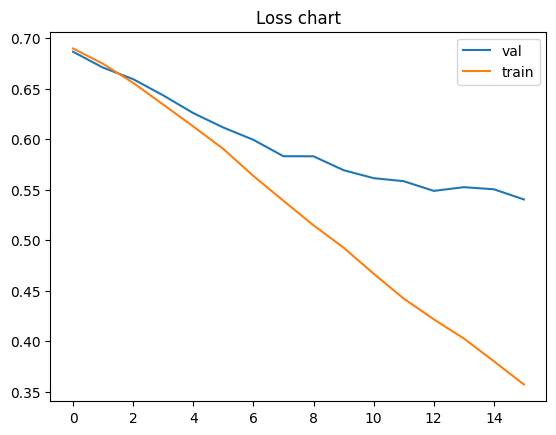

In [ ]:
plt.plot(v_loss[:16], label='val')
plt.plot(t_loss[:16], label='train')
plt.legend(loc='upper right')
plt.title('Loss chart')
plt.show()

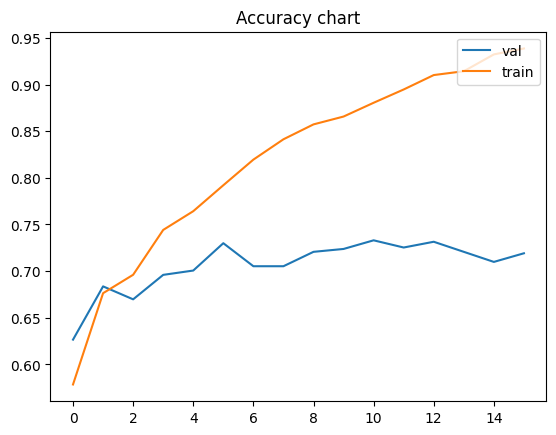

In [ ]:
plt.plot(v_acc[:16], label='val')
plt.plot(t_acc[:16], label='train')
plt.legend(loc='upper right')
plt.title('Accuracy chart')
plt.show()

##Evaluation DADGNN

Test Loss: 0.5566, Test Accuracy: 0.7188
Precision: 0.7206, Recall: 0.7196, F1 Score: 0.7186


Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.76      0.73       792
           1       0.75      0.68      0.71       826

    accuracy                           0.72      1618
   macro avg       0.72      0.72      0.72      1618
weighted avg       0.72      0.72      0.72      1618
 



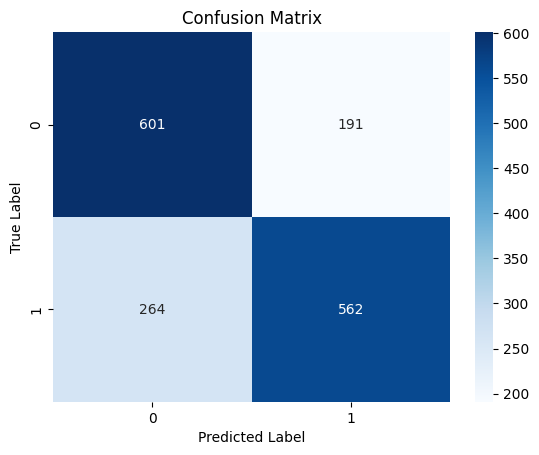

In [ ]:
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

test_loss, test_acc, precision, recall, f1 = evaluate_model(model_dif, test_loader, criterion)

The results are average across all the models that we tried. Also it classifies class 1 worse than 0.

Previously we tried passing weights of classes to the criterion, even though the balance between the classes in train and validation samples (after their splitting) is fine. But by a certain tuning of the parameters (increasing the number of heads) this problem became a bit less visible, but still exists.



---



---



---





---



---





---



---



---



#Environment settings for Tensorflow models

For the sake of experiment, we went back to good old keras models to compare their results with those of graph models

In [ ]:
!pip install --force-reinstall -v "numpy==1.25.2"

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Link requires a different Python (3.11.11 not in: '>=3.7,<3.11'): https://files.pythonhosted.org/packages/3a/be/650f9c091ef71cb01d735775d554e068752d3ff63d7943b26316dc401749/numpy-1.21.2.zip (from https://pypi.org/simple/numpy/) (requires-python:>=3.7,<3.11)
  Link requires a different Python (3.11.11 not in: '>=3.7,<3.11'): https://files.pythonhosted.org/packages/5f/d6/ad58ded26556eaeaa8c971e08b6466f17c4ac4d786cd3d800e26ce59cc01/numpy-1.21.3.zip (from https://pypi.org/simple/numpy/) (requires-python:>=3.7,<3.11)
  Link requires a different Python (3.11.11 not in: '>=3.7,<3.11'): https://files.pythonhosted.org/packages/fb/48/b0708ebd7718a8933f0d3937513ef8ef2f4f04529f1f66ca86d873043921/numpy-1.21.4.zip (from https://pypi.org/simple/numpy/) (requires-python:>=3.7,<3.11)
  Link requires a different Python (3.11.11 not in: '>=3.7,<3.11'): https://files.pythonhosted.org/packages/c2/a8/a924a09492bdfee8c2ec3094d0

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

train_df = load_dataset("siddhant4583agarwal/sarcasm-detection-dataset", split="train").to_pandas()
test_df = load_dataset("siddhant4583agarwal/sarcasm-detection-dataset", split="test").to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(




---



---



---



In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True



---



In [ ]:
train_df = train_df.drop_duplicates()

In [ ]:
test_df = test_df[~test_df['text'].str.startswith('st miras college for girls', na=False)]



---



In the preprocessing steps are similar:

In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

train_df['preprocessed'] = train_df['text'].apply(preprocess_text)
test_df['preprocessed'] = test_df['text'].apply(preprocess_text)

Then we are looking at lengths of texts to find the fitting padding length:

Text length median: 9.0
Text length mean: 8.870828182941903


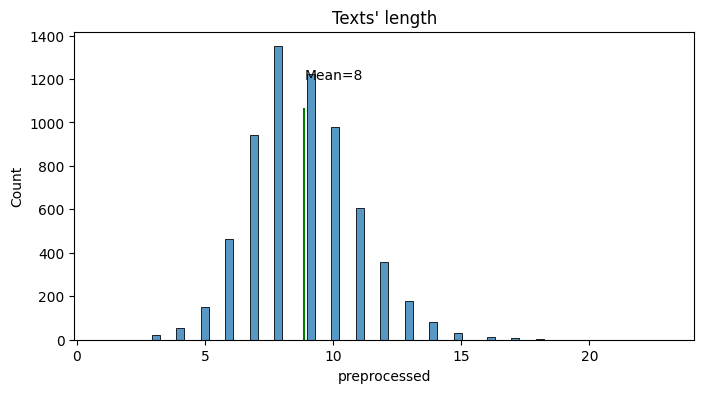

In [ ]:
text_lengths = train_df['preprocessed'].apply(lambda x: len(x.split()))
print('Text length median:', np.median(text_lengths, axis=0))
print('Text length mean:', np.mean(text_lengths, axis=0))

plt.figure(figsize=(8, 4))
sns.histplot(text_lengths)
plt.title("Texts' length")
plt.axvline(x=np.mean(text_lengths), ymin=0, ymax=0.75, color='g')
plt.text(np.mean(text_lengths), 1200, f'Mean={int(np.mean(text_lengths))}')
plt.show()

##Processing

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, Embedding, GRU, GlobalMaxPooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2, L2
from tensorflow.keras.preprocessing.text import Tokenizer

we choose a value slightly larger than the average text length and use the keras tokenizer for numerical representations:

In [ ]:
max_sequence_length = 10

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['preprocessed'])

X_train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed'])

X_train_p = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_p = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

y_train = np.array(train_df['label'].to_list())
y_test = np.array(test_df['label'].to_list())

In [ ]:
X_train_p.shape

(6472, 10)

#Tf models

We are trying out a RNN and CNN models. For the first one we decided to go with GRU

##GRU

In [ ]:
embedding_size = 64
max_sequence_length = X_train_p.shape[1]


input_layer = tf.keras.Input(shape=(max_sequence_length,))

x = Embedding(input_dim=10000, output_dim=embedding_size, input_length=max_sequence_length)(input_layer)

x = GRU(64, return_sequences=False)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_12 (Embedding)             │ (None, 10, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 667,585 (2.55 MB)

 Trainable params: 667,585 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_test), y=y_test)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(X_train_p, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)],
                    class_weight=class_weights_dict)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5230 - loss: 0.6927 - val_accuracy: 0.5077 - val_loss: 0.6920
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5328 - loss: 0.6912 - val_accuracy: 0.5077 - val_loss: 0.6910
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5465 - loss: 0.6894 - val_accuracy: 0.5417 - val_loss: 0.6900
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5657 - loss: 0.6878 - val_accuracy: 0.5787 - val_loss: 0.6888
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5873 - loss: 0.6855 - val_accuracy: 0.6111 - val_loss: 0.6875
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6055 - loss: 0.6846 - val_accuracy: 0.6235 - val_loss: 0.6862
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6304 - loss: 0.6824 - val_accuracy: 0.6281 - val_loss: 0.6849
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6221 - loss: 0.6814 - val_accuracy: 0.6204 - v

**Graphs**

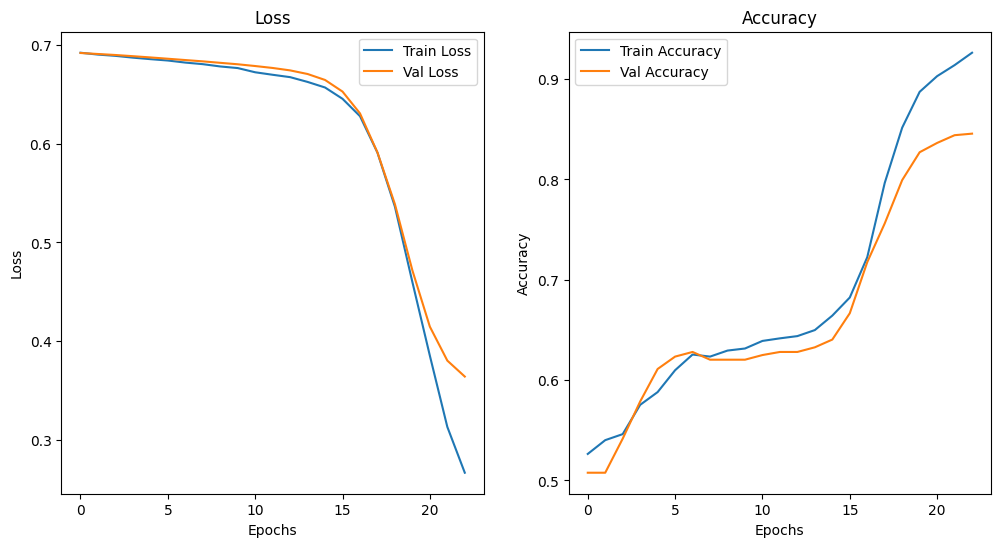

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][:23], label='Train Loss')
plt.plot(history.history['val_loss'][:23], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'][:23], label='Train Accuracy')
plt.plot(history.history['val_accuracy'][:23], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

It seems a bit strange that at first the loss curve remains at a fairly high level for many epochs. However, then it rapidly begins to fall, showing such results before the training stops.

###Evaluation

now predicting and getting evaluation results on test data:

In [ ]:
pred_y = model.predict(X_test_p)

prediction = (pred_y > 0.5).astype(int).flatten()

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       792
           1       0.87      0.82      0.85       826

    accuracy                           0.85      1618
   macro avg       0.85      0.85      0.85      1618
weighted avg       0.85      0.85      0.85      1618



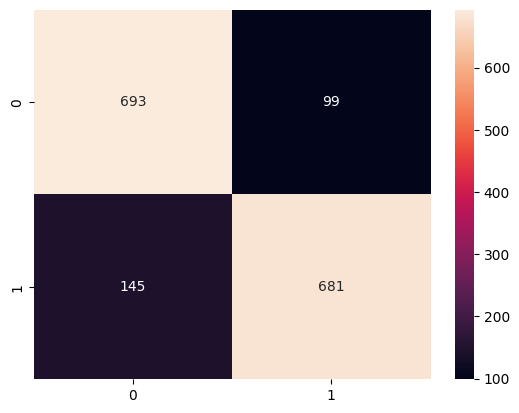

In [ ]:
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt="d")

plt.show()

We consider that pretty good after our previous results. Both classes are well predicted.

##CNN

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

embedding_size = 64
num_classes = 1
max_sequence_length = X_train_p.shape[1]

input_layer = tf.keras.Input(shape=(max_sequence_length,))

x = Embedding(input_dim=10000, output_dim=embedding_size, input_length=max_sequence_length)(input_layer)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_cnn = Model(inputs=input_layer, outputs=output_layer)

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=7e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 10, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 8, 64)               │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 679,137 (2.59 MB)

 Trainable params: 679,137 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_test), y=y_test)
class_weights_dict = dict(enumerate(class_weights))

history = model_cnn.fit(X_train_p, y_train,
                        epochs=30,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)],
                        class_weight=class_weights_dict)

Epoch 1/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5051 - loss: 0.6937 - val_accuracy: 0.5093 - val_loss: 0.6927
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5722 - loss: 0.6915 - val_accuracy: 0.6204 - val_loss: 0.6884
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6542 - loss: 0.6832 - val_accuracy: 0.6497 - val_loss: 0.6747
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7065 - loss: 0.6547 - val_accuracy: 0.7531 - val_loss: 0.6154
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8180 - loss: 0.5530 - val_accuracy: 0.7963 - val_loss: 0.4920
Epoch 6/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9016 - loss: 0.3588 - val_accuracy: 0.8025 - val_loss: 0.4151
Epoch 7/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9345 - loss: 0.2321 - val_accuracy: 0.8117 - val_loss: 0.3909
Epoch 8/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9557 - loss: 0.1627 - val_accu

**Graphs**

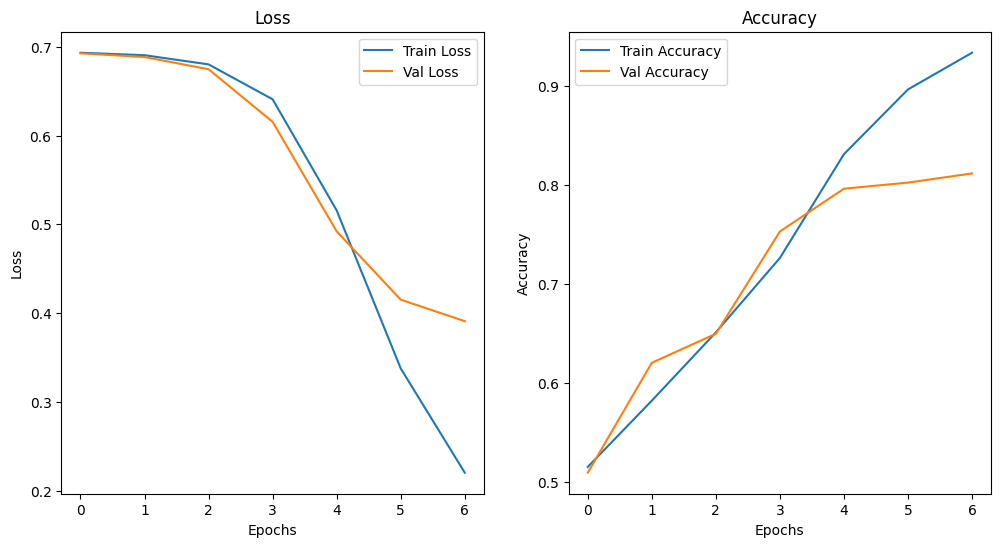

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][:7], label='Train Loss')
plt.plot(history.history['val_loss'][:7], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'][:7], label='Train Accuracy')
plt.plot(history.history['val_accuracy'][:7], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

There weren't many epochs, but the dynamics are quite good.

###Evaluation

In [ ]:
pred_y = model_cnn.predict(X_test_p)

prediction = (pred_y > 0.5).astype(int).flatten()

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       792
           1       0.86      0.83      0.85       826

    accuracy                           0.85      1618
   macro avg       0.85      0.85      0.85      1618
weighted avg       0.85      0.85      0.85      1618



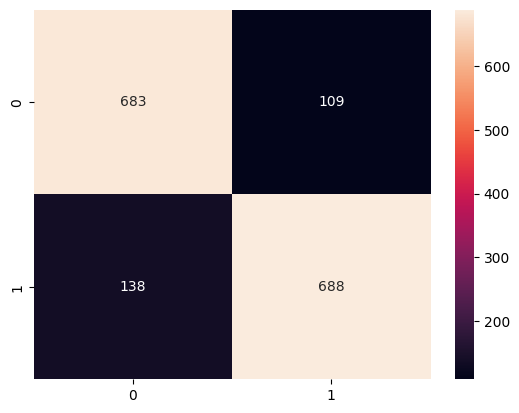

In [ ]:
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt="d")

plt.show()

As well as the model with a GRU layer, this one is is quite stable and its predictions are mostly correct for both classes.



---



---



---



#Comparison of all the models

* Graph models

Unfortunately, the graph models did not particularly please with their results (but at least they are not totally random). Maybe, working with them for the first time, we simply couldn't think of the right way to tune them better

In general, most of them had similar evaluation criteria, but if we were to compile a top list based on the metrics:

1. GAT with Transformer-based attention



```
Test Loss: 0.5464, Test Accuracy: 0.7355
Precision: 0.7376, Recall: 0.7364, F1 Score: 0.7353
```

2. SAGE


```
Test Loss: 0.5254, Test Accuracy: 0.7328
Precision: 0.7476, Recall: 0.7354, F1 Score: 0.7301
```

3. GAT self-attention


```
Test Loss: 0.5379, Test Accuracy: 0.7244
Precision: 0.7244, Recall: 0.7245, F1 Score: 0.7243
```

4. GAT with Edge-weighted attention



```
Test Loss: 0.5417, Test Accuracy: 0.7231
Precision: 0.7237, Recall: 0.7235, F1 Score: 0.7231
```

5. **DADGNN**


```
Test Loss: 0.5566, Test Accuracy: 0.7188
Precision: 0.7206, Recall: 0.7196, F1 Score: 0.7186
```

6. GCN:

```
Test Loss: 0.5600, Test Accuracy: 0.6910
Precision: 0.7055, Recall: 0.6880, F1 Score: 0.6832
```


The trend we found here is that models without attention (GCN, SAGE) have a harder time predicting classes equally correctly (with and without passing class weights to the model). That is, they usually predict one class well (due to which the metric grows), but the second class has quite a lot of errors. Models with attention cope with this problem better.


---


* Keras models

In general they both got better results:

Model with GRU layer:



```
     precision    recall  f1-score   support

0       0.83      0.88      0.85       792
1       0.87      0.82      0.85       826

    accuracy - 0.85
```

Model with Conv1D layer:



```
     precision    recall  f1-score   support

0       0.83      0.86      0.85       792
1       0.86      0.83      0.85       826

    accuracy - 0.85
```

The accuracies of the models are the same, but due to the relationship of metrics between classes, we will call the CNN model the best.











#Saving a model and implementiong it into a service

For the service we used one of the best model - recurrent network with GRU

In [ ]:
import pickle

model.save("gru_text_model.h5")

with open("tokenizer.pkl", "wb") as f:
  pickle.dump(tokenizer, f)

The implementation is here: https://github.com/YuliaVodopyanova/Simple_api_service